In this notebook we are looking into optimizing a linear regression/regressor using gradient descent. 
The key takeaways are:

Conceptual:
1. Be able to explain what a gradient descent in two dimensions is. 

Technical:
1. Gain experience with tensor-indexing and tensor arithmetic (e.g. matmul; know the order in which the data is organized into tensors: (batch size, features)
2. Get acquinted with exploring the data (represented as tensors), numeracilly and by using Matplotlib. Be able to use Matplotlib to run simple visualization.
3. Understand the concepts and terms: forward-pass, backward-pass, training, optimization, weights, nodes/neurons, 
4. 


In [1]:
import torch
import matplotlib.pyplot as plt
import helpers as h
from math import floor, ceil

In [2]:
torch.manual_seed(42)

### Setting the Data

In [3]:
NUMBER_OF_DATA_POINTS = 4
X_RANGE = {
    'min': 0,
    'max': 2
}
SLOPE = 3
INTERCEPT = 4
NOISE_RANGE = 1.5
m = NUMBER_OF_DATA_POINTS  # number of instances (the number of data-points)

def generate_data(
    x_range:dict[str, str]=X_RANGE,
    number_of_data_points:int=NUMBER_OF_DATA_POINTS,
    slope:float=SLOPE,
    intercept:float=INTERCEPT,
    noise_range:float=NOISE_RANGE
    ) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Generates data for linear regression.
    """
    range = X_RANGE['max'] - X_RANGE['min']
    X = x_range['min'] + (range * torch.rand(size=(number_of_data_points, 1)))  # randomly-generated x-values, taken from a uniform distribution within `x_range`
    y = intercept + (slope * X) + (((torch.rand(size=(number_of_data_points, 1)) - 0.5) * 2) * noise_range)  # y-values with uniformaliy distributed noise added
    return X, y

def calculate_y_range(
    x_range:dict[str, str]=X_RANGE,
    slope:float=SLOPE,
    intercept:float=INTERCEPT,
    noise_range:float=NOISE_RANGE,
    ) -> float:
    """
    Calculates the maximum y-value for a given x-range, taking into account the maximum noise.
    """
    y_range = {}
    if slope >= 0:
        y_range['min'] = intercept + (slope * x_range['min']) - noise_range
        y_range['max'] = intercept + (slope * x_range['max']) + noise_range
    elif slope < 0:
        y_range['min'] = intercept + (slope * x_range['min']) + noise_range
        y_range['max'] = intercept + (slope * x_range['max']) - noise_range
    return y_range

X, y = generate_data()
y_range = calculate_y_range()

In [4]:
h.print_tensor_info(X, fields=['Tensor', 'Dimension', 'Shape'])

Tensor       tensor([[1.7645],
        [1.8300],
        [0.7657],
        [1.9186]])
Dimension    2
Shape        (4, 1)


The many PyTorch (and Tensorflow) functions expect their input to be in the shape of (batch_size, features). Note that above `X` was defined accordingly. The number of data points (also called instances), is generally always in the 0th dimension. 

In [5]:
h.print_tensor_info(y, fields=['Tensor', 'Dimension', 'Shape'])

Tensor       tensor([[ 8.9650],
        [ 9.7927],
        [ 5.5669],
        [10.6368]])
Dimension    2
Shape        (4, 1)


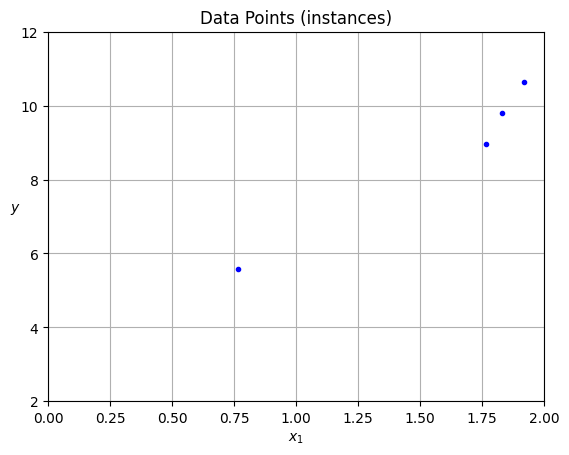

In [6]:
def plot_data_points(X, y):
    plt.plot(X, y, "b.")
    plt.xlabel("$x_1$")
    plt.ylabel("$y$", rotation=0)
    plt.title("Data Points (instances)")
    plt.axis([X_RANGE['min'], X_RANGE['max'], floor(y_range['min']), ceil(y_range['max'])])
    plt.grid()
    plt.show()
    return

plot_data_points(X, y)

### Preprocessing the Data

Now we are adding a dummy input parameter, that is equal to one for all instances: $x_0=1$.
This will allow us to use a single matrix multiplication for the equation $y =  w_0*1 + w_1*x_1$. It  is the genric form of a 1-dimensional linear equation. 

(for additional optional context, see: [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.add_dummy_feature.html))

In [7]:
X_extended = torch.cat((torch.full(X.shape, 1), X), 1)

In [8]:
h.print_tensor_info(X_extended, fields=['Tensor', 'Dimension', 'Shape'])

Tensor       tensor([[1.0000, 1.7645],
        [1.0000, 1.8300],
        [1.0000, 0.7657],
        [1.0000, 1.9186]])
Dimension    2
Shape        (4, 2)


### Defining the Model
With this form of input we can define the parameters: $w_0$ and $w_1$.
The equation is $y = w_0*x_0 + w_1*x_1$, or in a matrix notation: $y = X @ W$.
It might be helpful to write with PyTorch. 

In [1]:
def model(X, W):
    return X @ W

Let's assign values for our parameters, $W$

In [9]:
W = torch.tensor([[1.], [2.]])  # usually the parameters are randmoly set
# TODO change the above to a random initialization, and see what happens.
# Then change it to a zero initialization, and see what happens.
# Lastly, try setting it to the mean of the y values, with zero slope.

In [10]:
h.print_tensor_info(W, fields=['Tensor', 'Dimension', 'Shape'])

Tensor       tensor([[1.],
        [2.]])
Dimension    2
Shape        (2, 1)


In [11]:
def predict(X: torch.Tensor, W: torch.Tensor, is_preprocessed=False) -> torch.Tensor:
    """
    Calculates the value of a linear function with parameters W at points X.

    X: torch tensor of shape (number_of_points_to_predict, 1)
    W: torch tensor of shape (2, 1)
    return: torch tensor of shape (number_of_points_to_predict, 1)

    """
    if is_preprocessed:
        X_extended = X
    else:
        X_extended = torch.cat((torch.full(X.shape, 1), X), 1)  # preprocess
    y_predicted = model(X_extended, W)
    return y_predicted

In [12]:
y_predicted = predict(X_extended, W, is_preprocessed=True)

In [13]:
h.print_tensor_info(y_predicted, fields=['Tensor', 'Dimension', 'Shape'])

Tensor       tensor([[4.5291],
        [4.6600],
        [2.5315],
        [4.8372]])
Dimension    2
Shape        (4, 1)


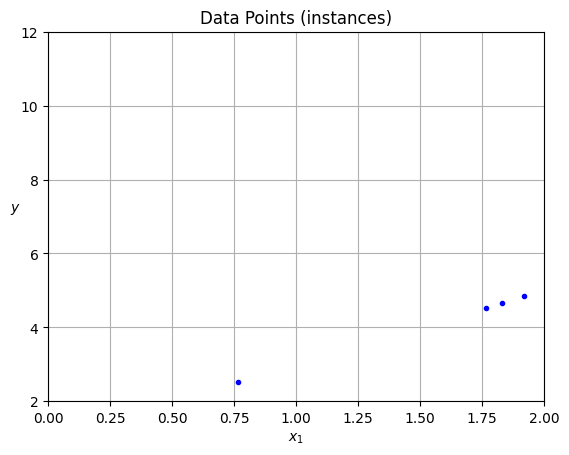

In [14]:
plot_data_points(X, y_predicted)

### Setting up a Loss Function
We need to define a cost-function - which is the value to be optimized.
First let's plot the data points and the predictions on the same graph: 

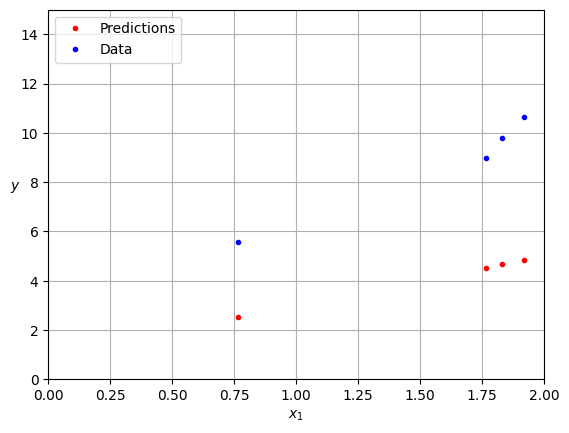

In [15]:
# TODO fix - there is no red line on the plot
plt.plot(X, y_predicted, "r.", label="Predictions")
plt.plot(X, y, "b.", label="Data")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")

plt.show()

The loss function we are going to use is the squared mean error (SME):

$L=\frac{1}{m}*\sum_{n=1} ^{m} (y_{predicted, n} - y_n)^2$

In [ ]:
def loss(y_predicted, y):
    sme = ((y_predicted - y) ** 2).mean()  # squared mean error. This is equivalent to: torch.sum((y_predicted - y)**2)/y.numel()
    return sme

In [16]:
# First, demonstrating the calculation of the loss for each instance:
print('Squared error per instance:')
print((y_predicted - y)**2)

Squared error per instance:
tensor([[19.6771],
        [26.3445],
        [ 9.2139],
        [33.6346]])


In [17]:
sme = torch.sum((y_predicted - y)**2)/y.numel()
print(f'SME: {sme:.4}')

SME: 22.22


In [ ]:
sme = loss(y_predicted, y)
print(f'SME: {sme:.4}')

### Optimization
Next we can manually calculate the derivative and use it for gradient descent

The cost function per instance is: $(w0 + w_1*x_1 - y)^2$
There are two partial derivatives for this equation, one for each of the two parameters:

$\frac{\partial(F)}{\partial(w_0)} = 2*(w0 + w_1*x_1 - y)$

$\frac{\partial(F)}{\partial(w_1)} = 2*(w0 + w_1*x_1 - y)*x_1$

Let's look at these two equations to get some intution. The only difference between the two is the multiplciation by $x_1$ for $\frac{\partial(f)}{\partial(w_1)}$ but not for $\frac{\partial(f)}{\partial(w_0)}$. This make intuitive sense, given that as $x_1$ is larger, a change in the slope ($w_1$) would be more meaningful, it will gain a larger difference for a larger $x_1$ than a smaller one.

In [18]:
d_w0 = 2*(X_extended @ W - y)
d_w1 = 2*(X_extended @ W - y) * X_extended[:, 1].reshape(-1, 1)

In [19]:
d_w0

tensor([[ -8.8718],
        [-10.2654],
        [ -6.0709],
        [-11.5991]])

In [20]:
d_w1

tensor([[-15.6546],
        [-18.7857],
        [ -4.6486],
        [-22.2541]])

And to get each partial derivative over all instances:

In [21]:
d_w0_mean = torch.mean(d_w0)
d_w1_mean = torch.mean(d_w1)
print(f'd_w0_mean: {d_w0_mean:.4}')
print(f'd_w1_mean: {d_w1_mean:.4}')

d_w0_mean: -9.202
d_w1_mean: -15.34


Notice that the gradient points to the direction of maximum increase of the loss function. And since the loss need to minimized, the direction to take is that of its opposite. 

And now we can define a learning rate, which is a multiplier of the gradient

In [35]:
lr = 0.02
print(f'Learning Rate: {lr:.4}')

Learning Rate: 0.02


Before we run the gradient iteratively, let's run the first iteration, and take a look at the value of the parameters, its graphical reporesentation, 

In [23]:
# TODO: Here we want to simply print W before and after applying the gradients.model
# For this, we need to define W_new by _cloning_ the original W. 
# why is this necessary? Can you explain? 
# More precisely, what is the difference between `W_new = W`` and `W_new = W.clone()`?
W_new = W.clone()

In [24]:
W_new[0] = W_new[0] - lr * d_w0_mean
W_new[1] = W_new[1] - lr * d_w1_mean
print(W)
print(W_new)

tensor([[1.],
        [2.]])
tensor([[1.0920],
        [2.1534]])


In [25]:
y_predicted = predict(X_extended, W_new, is_preprocessed=True)

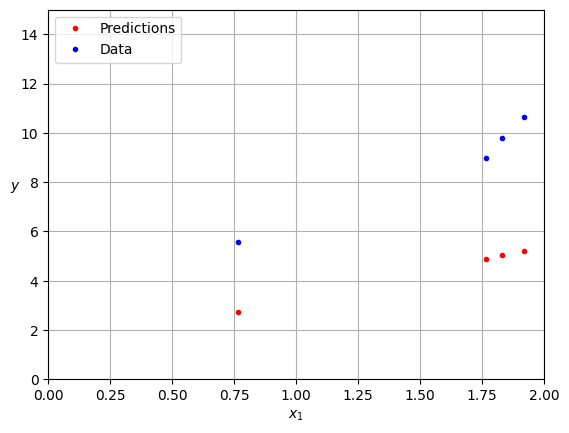

In [26]:
# TODO fix - there is no red line on the plot
plt.plot(X, y_predicted, "r.", label="Predictions")
plt.plot(X, y, "b.", label="Data")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")

plt.show()

Now we can run the optimization iteratively. 
We can save the values of the parameters, and the loss. We can also plot them. 

In [33]:
W.numpy()[0][0]

2.2826645

In [36]:
for epoch in range(25):
    y_predicted = predict(X_extended, W, is_preprocessed=True)
    sme = torch.sum((y_predicted - y)**2)/y.numel()
    d_w0_mean = torch.mean(2*(X_extended @ W - y))
    d_w1_mean = torch.mean(2*(X_extended @ W - y) * X_extended[:, 1].reshape(-1, 1))
    W[0] = W[0] - lr * d_w0_mean
    W[1] = W[1] - lr * d_w1_mean
    print(f'Epoch {epoch}: SME: {sme:.4} W_0: {W.numpy()[0][0]:.4} W_1: {W.numpy()[1][0]:.4}')

Epoch 0: SME: 0.1406 W_0: 2.296 W_1: 4.101
Epoch 1: SME: 0.1406 W_0: 2.297 W_1: 4.101
Epoch 2: SME: 0.1406 W_0: 2.297 W_1: 4.101
Epoch 3: SME: 0.1406 W_0: 2.297 W_1: 4.101
Epoch 4: SME: 0.1406 W_0: 2.297 W_1: 4.101
Epoch 5: SME: 0.1406 W_0: 2.298 W_1: 4.1
Epoch 6: SME: 0.1406 W_0: 2.298 W_1: 4.1
Epoch 7: SME: 0.1406 W_0: 2.298 W_1: 4.1
Epoch 8: SME: 0.1406 W_0: 2.298 W_1: 4.1
Epoch 9: SME: 0.1406 W_0: 2.299 W_1: 4.1
Epoch 10: SME: 0.1406 W_0: 2.299 W_1: 4.1
Epoch 11: SME: 0.1406 W_0: 2.299 W_1: 4.1
Epoch 12: SME: 0.1405 W_0: 2.299 W_1: 4.099
Epoch 13: SME: 0.1405 W_0: 2.3 W_1: 4.099
Epoch 14: SME: 0.1405 W_0: 2.3 W_1: 4.099
Epoch 15: SME: 0.1405 W_0: 2.3 W_1: 4.099
Epoch 16: SME: 0.1405 W_0: 2.3 W_1: 4.099
Epoch 17: SME: 0.1405 W_0: 2.301 W_1: 4.099
Epoch 18: SME: 0.1405 W_0: 2.301 W_1: 4.099
Epoch 19: SME: 0.1405 W_0: 2.301 W_1: 4.098
Epoch 20: SME: 0.1405 W_0: 2.301 W_1: 4.098
Epoch 21: SME: 0.1405 W_0: 2.302 W_1: 4.098
Epoch 22: SME: 0.1405 W_0: 2.302 W_1: 4.098
Epoch 23: SME: 0.140

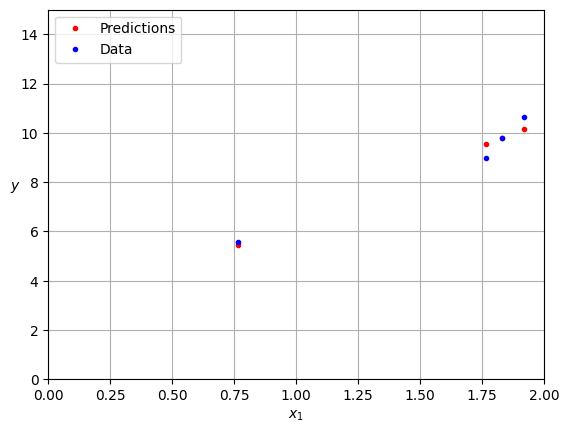

In [37]:
# TODO fix - there is no red line on the plot
plt.plot(X, y_predicted, "r.", label="Predictions")
plt.plot(X, y, "b.", label="Data")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")

plt.show()

It might be interesting to see what happens if we change the learning rate.

### Note about Alternatives
There are other ways to solve a linear regression problem. In fact, thee is an exact method (with computational limitations, that we will review in a moment). It can be useful to compare the result we got to the ideal one (it can be proved mathematically that it is the ideal solution).

In [10]:
ideal_w = torch.inverse(X.T @ X) @ X.T @ y
print(ideal_w)
print(ideal_w.shape)
print(ideal_w.dim())

tensor([[3.9489],
        [3.5203]])
torch.Size([2, 1])
2
